# Technical setup
> Skip this section

In [17]:
# @formatter:off

In [18]:
%%time
%reload_ext autoreload
%autoreload 2
# @formatter:on

CPU times: user 4.93 ms, sys: 7.36 ms, total: 12.3 ms
Wall time: 12.2 ms


# Parameters

In [19]:
symbol = 'ETHUSDT'
symbol_k_lines_interval = '1s'
symbol_ask_bid_price_difference = 0.01
price_step_ratio = 0.001

# Ticks

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


,timestamp,bid_price,ask_price
0,1677628800000,1605.24,1605.25
1,1677628801000,1605.46,1605.47
2,1677628802000,1605.46,1605.47
3,1677628803000,1605.46,1605.47
4,1677628804000,1605.47,1605.48
...,...,...,...
86395,1681775995000,2074.00,2074.01
86396,1681775996000,2074.00,2074.01
86397,1681775997000,2074.00,2074.01
86398,1681775998000,2074.00,2074.01


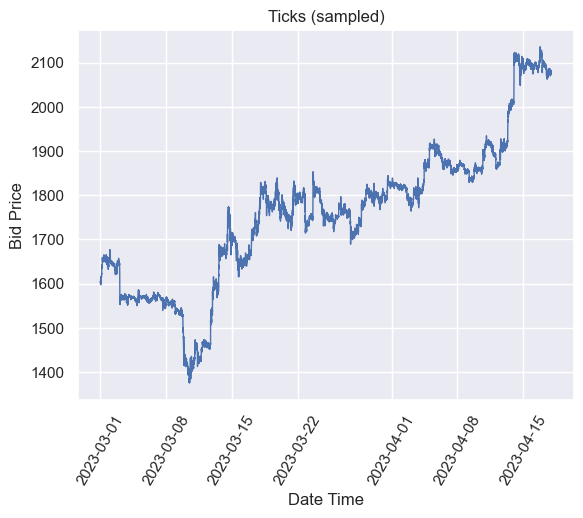

In [20]:
from IPython.core.display_functions import display

from binance.binance_k_line_loader import load_binance_k_lines
from binance.binance_tick_loader import load_binance_ticks
from chart.ttm_chart import draw_line_chart

k_lines = load_binance_k_lines(f"../../../ttm-data/{symbol}-{symbol_k_lines_interval}-*.csv")

ticks = load_binance_ticks(k_lines, symbol_ask_bid_price_difference)

draw_line_chart(ticks, 'timestamp', 'bid_price', 'Bid Price', 'Ticks')

display(ticks)

# Simulation Setup

In [21]:
# @formatter:off

In [22]:
%%time
# @formatter:on

from trade.trade_simulator import TradeSimulator

trade_simulator: TradeSimulator = TradeSimulator(ticks)

CPU times: user 51.9 s, sys: 565 ms, total: 52.5 s
Wall time: 52.4 s


# Simulation

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


'orders: 30,049, avg price change: 0.06, tx avg price margin: 1.99, tx avg profit: -0.04, tx cum profit: -1199.56'

,open_timestamp,type,open_price,close_price,price_margin,close_timestamp,profit,cumulative_profit
0,1.677629e+12,BUY,1603.36,1601.48,1.88,1.677629e+12,-1.88,-1.88
1,1.677629e+12,BUY,1601.49,1603.28,1.79,1.677630e+12,1.79,-0.09
2,1.677630e+12,SELL,1603.28,1605.15,1.87,1.677630e+12,-1.87,-1.96
3,1.677630e+12,SELL,1605.14,1606.81,1.67,1.677630e+12,-1.67,-3.63
4,1.677630e+12,SELL,1606.80,1608.50,1.70,1.677630e+12,-1.70,-5.33
...,...,...,...,...,...,...,...,...
30044,1.681772e+12,BUY,2078.75,2076.38,2.37,1.681773e+12,-2.37,-1201.32
30045,1.681773e+12,BUY,2076.39,2073.92,2.47,1.681774e+12,-2.47,-1203.79
30046,1.681774e+12,BUY,2073.93,2076.20,2.27,1.681775e+12,2.27,-1201.52
30047,1.681775e+12,SELL,2076.20,2074.12,2.08,1.681775e+12,2.08,-1199.44


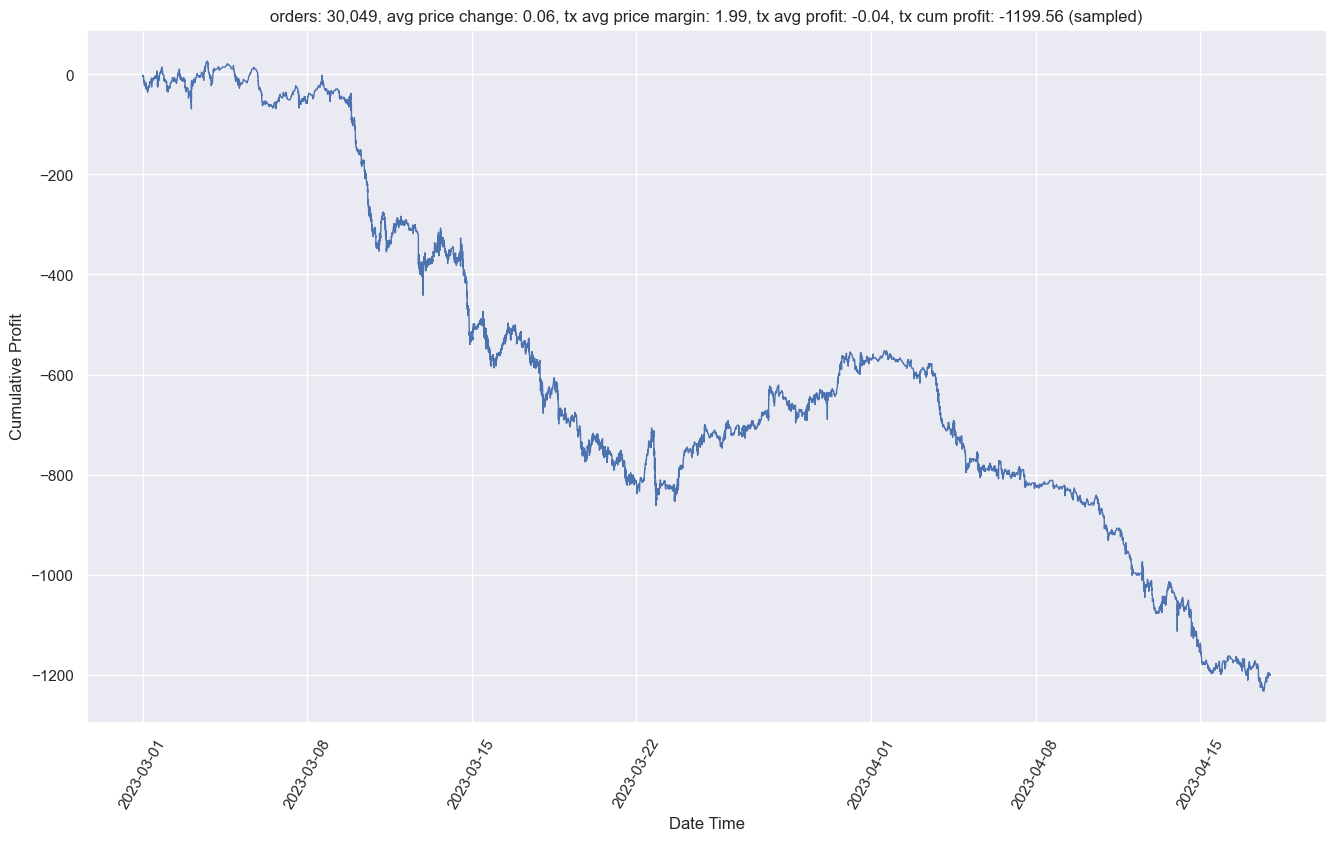

In [52]:
from analytics.bot_strategy_0 import BotStrategy0

transactions = trade_simulator.simulate(BotStrategy0(price_step_ratio))

# 'orders: 30,049, avg. price margin: 1.99, avg. profit: -0.04, cum. profit: -1199.56'
result_str = (f"orders: {len(transactions.index):,}"
              f", avg price change: {ticks.ask_price.diff().abs().mean():.2f}"
              f", tx avg price margin: {transactions.price_margin.mean():.2f}"
              f", tx avg profit: {transactions.profit.mean():.2f}"
              f", tx cum profit: {transactions.cumulative_profit.iloc[-1]:.2f}")

draw_line_chart(transactions, 'open_timestamp', 'cumulative_profit', 'Cumulative Profit', result_str)
display(result_str)
display(transactions)